# 5. Analytics tools (tg.common.analysis)

## Overview

`tg.common.analysis` is a module with some helpful analytics tools, mostly around the concept of statistical significance, with the aim to make it easier to use this concept and visualize the results in the report. Currently, very few features are implemented, but those are extremely useful for the meaningful reports.

## `percentile_confint`


As a model example, we will use Titanic dataset again, particularly around the question "which features are most useful to predict the outcome". We have demonstrated this technique in `tg.common.ml.single_frame_training`, but it's also implemented as ready to use solution in `tg.common.analytics`.

In [1]:
import pandas as pd
df = pd.read_csv('titanic.csv')
df = df.set_index('PassengerId')
for c in ['Pclass','SibSp','Parch','Survived']:
    df[c] = df[c].astype(float)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
3,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
5,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S


In [2]:
from tg.common.analysis import FeatureSignificance
from tg.common import Logger

Logger.disable()

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
significance = FeatureSignificance.for_classification_task(
    df = df,
    features = features,
    label = 'Survived',
    folds_count = 200
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [3]:
significance.head()

,Pclass,Age,SibSp,Parch,Fare,Age_missing,Sex_male,Sex_female,Embarked_S,Embarked_C,Embarked_Q,Embarked_NULL
0,-0.861870,-0.571329,-0.430517,-0.095062,0.062456,-0.301913,-1.334796,1.334920,-0.418228,0.062635,0.186314,0.169403
1,-0.985657,-0.617876,-0.347725,0.038203,-0.034456,-0.428030,-1.381279,1.381317,-0.427300,0.050905,0.243914,0.132519
2,-0.954792,-0.669994,-0.404068,-0.043028,-0.005523,-0.355824,-1.395271,1.395354,-0.373559,0.122871,0.050387,0.200385
3,-0.945720,-0.658512,-0.478880,-0.050786,0.294873,-0.200040,-1.372717,1.372751,-0.461177,0.151009,0.210827,0.099375
4,-0.877177,-0.507637,-0.273289,-0.022627,0.099942,-0.472386,-1.226026,1.226146,-0.434261,0.054348,0.209524,0.170508


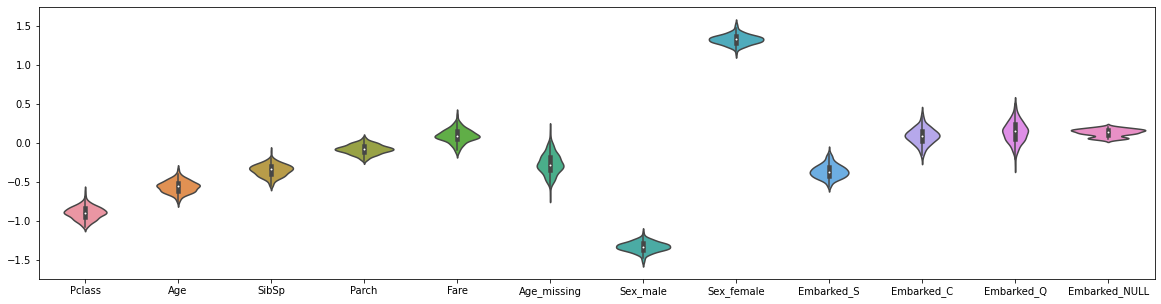

In [4]:
from matplotlib import pyplot as plt
from seaborn import violinplot

_, ax = plt.subplots(1,1,figsize=(20,5))
violinplot(data=significance, ax=ax)
pass

We see that some of the feature are reallyfar from zero (like `Sex_male` and `Sex_female`), but some others are near and it's hard to say, if there are significant. To answer this question, we can build a confidence intervals:

In [5]:
sdf = significance.unstack().to_frame().reset_index()
sdf.columns = ['feature','experiment','value']
sdf.head()

,feature,experiment,value
0,Pclass,0,-0.861870
1,Pclass,1,-0.985657
2,Pclass,2,-0.954792
3,Pclass,3,-0.945720
4,Pclass,4,-0.877177


In [6]:
from tg.common.analysis import Aggregators
sdf1 = sdf.groupby('feature').value.feed(Aggregators.percentile_confint(pValue=0.9)).reset_index()
sdf1.head()

,feature,value_lower,value_upper,value_value,value_error
0,Age,-0.670278,-0.440688,-0.555483,0.114795
1,Age_missing,-0.482734,-0.031772,-0.257253,0.225481
2,Embarked_C,-0.080599,0.239275,0.079338,0.159937
3,Embarked_NULL,NaN,NaN,NaN,NaN
4,Embarked_Q,-0.080665,0.360177,0.139756,0.220421


This aggregator is essentially doing what `mean` or `std` functions do, but for statistical significance. 

Now, we can use `grbar_plot` for visualization:

<AxesSubplot:xlabel='value_value', ylabel='feature'>

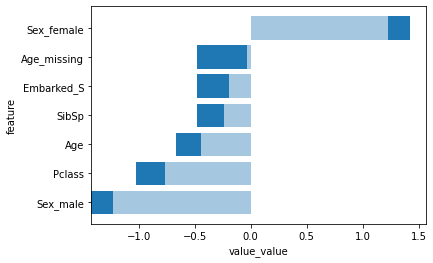

In [7]:
from tg.common.analysis import grbar_plot

grbar_plot(
    sdf1.loc[sdf1.value_upper*sdf1.value_lower>0].sort_values('value_upper'), 
    value_column='value_value', 
    error_column='value_error', 
    group_column='feature', orient='h'
)

## `proportion_confint`

Aside from `percentile_confint`, which builds a confidence interval by simply computing the borders in which the proper amount of values fall, there is `proportion_confint` that uses the formula for Bernoulli distribution.

In [8]:
df.Survived.feed(Aggregators.proportion_confint())

,Survived_lower,Survived_upper,Survived_value,Survived_error
0,0.351906,0.415771,0.383838,0.031932


As any Aggregator, it can be applied, e.g., to groups:

In [9]:
qdf = df.groupby(['Sex','Embarked']).Survived.feed(Aggregators.proportion_confint()).reset_index()
qdf

,Sex,Embarked,Survived_lower,Survived_upper,Survived_value,Survived_error
0,female,C,0.801294,0.952130,0.876712,0.075418
1,female,Q,0.608552,0.891448,0.750000,0.141448
2,female,S,0.626014,0.753296,0.689655,0.063641
3,male,C,0.212658,0.397868,0.305263,0.092605
4,male,Q,0.000000,0.152883,0.076441,0.076441
5,male,S,0.139172,0.210034,0.174603,0.035431


`grbar_plot` can also use two variables for drawing:

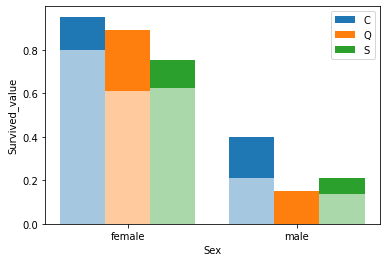

In [10]:
grbar_plot(
    qdf, 
    group_column='Sex', 
    color_column='Embarked', 
    value_column='Survived_value', 
    error_column='Survived_error')
plt.legend()

## Bootstrap

Let's explore if there is a significant difference between fares for men and women. 

In [11]:
df.groupby('Sex').Fare.mean()

Sex
female    44.479818
male      25.523893
Name: Fare, dtype: float64

Well, maybe, but is this difference significant? 

In this case, it's hard to use math: most of the cases are for normal distribution, but `Fare` is not distributed normally.

<AxesSubplot:>

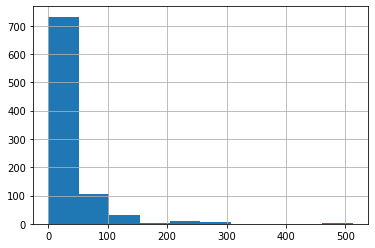

In [12]:
df.Fare.hist()

We can use [bootstraping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) for this task. To do so, first, we need a function that computes the value of interest as a dataframe:

In [13]:
def compute(df):
    return df.groupby('Sex').Fare.mean().to_frame().transpose().reset_index()
    
compute(df)

Sex,index,female,male
0,Fare,44.479818,25.523893


In [14]:
from tg.common.analysis import Bootstrap

bst = Bootstrap(df = df, method = compute)
rdf = bst.run(N=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
rdf.head()

,index,female,male,iteration,n
0,Fare,43.462195,26.987083,0,0
1,Fare,41.431770,25.906982,1,1
2,Fare,40.536302,27.590799,2,2
3,Fare,44.421407,25.357936,3,3
4,Fare,42.063531,24.546184,4,4


So, `Bootstrap` took subsamples of our task and computed means for each of them, creating the distribution of means:

<AxesSubplot:>

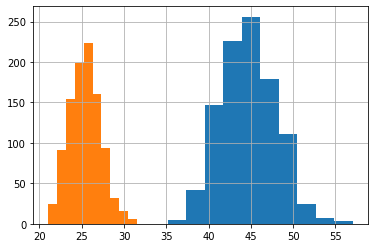

In [16]:
rdf.female.hist()
rdf.male.hist()

Those are normal, and bootsraping guarantees it (providing that mean value exists and enough samples are taken). 

So, we can use confidence intervals for normal distribution:

In [17]:
rdf[['female','male']].feed(Aggregators.normal_confint())

,female_lower,female_upper,female_value,female_error,male_lower,male_upper,male_value,male_error
0,39.053246,50.985264,45.019255,5.966009,22.117442,29.279721,25.698581,3.581139


When data are computed this way, it's not really easy to visualize, so:

<AxesSubplot:xlabel='sex', ylabel='fare_value'>

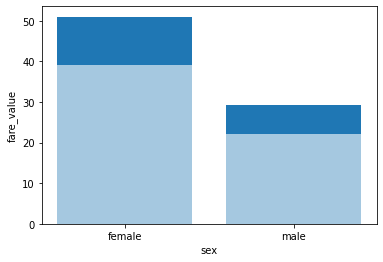

In [18]:
rdf1 = rdf[['female','male']].unstack().to_frame().reset_index()
rdf1.columns=['sex','iteration','fare']

grbar_plot(
    rdf1.groupby('sex').fare.feed(Aggregators.normal_confint()).reset_index(),
    value_column='fare_value',
    error_column='fare_error',
    group_column='sex'
)

The confidence intervals do not intersect (which, honestly, was quite visible from histogram), thus, the difference is significant.